In [1]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

# Running ISTDECO on the MOp data

In [2]:
# export
from decode_fish.imports import *

# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
import torch.nn as nn
import torch.nn.functional as F
from decode_fish.funcs.predict import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

sys.path.append('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/FQ/istdeco/')

from istdeco import ISTDeco

from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *

import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)

In [3]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_32/target_mean:Trueximage_path:scaled4_images151.tif//train.yaml')
artifact_coords = pd.read_csv('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/artifact_coords.csv')

In [4]:
codebook, targets = hydra.utils.instantiate(cfg.codebook)

In [5]:
micro_sd = torch.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_32/target_mean:Trueximage_path:scaled4_images151.tif/microscope.pkl')
ch_facs_151 = micro_sd['channel_facs']

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/cuda/__init__.py:122: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [6]:
dec_df = pd.read_csv('../data/results/MERFISH/merfish_sweep_mop_32_target_mean:Trueximage_path:scaled4_images151.tif_None_151.csv')
dec_df = dec_df[dec_df['code_inds'] < 252]
dec_df['gene'] = targets[dec_df['code_inds']]
dec_df['class'] = dec_df['gene'].str.contains('Blank')
res_single = remove_doublets(dec_df, tolerance=200)
dec_df = zero_int_ch(dec_df, codebook)
dec_df = remove_fids(dec_df, px_to_nm(artifact_coords), tolerance=1000)

In [7]:
img_5d = read_MOp_tiff(cfg.data_path.image_path, z_to_batch=True)

In [8]:
bench_151 = clean_bench_df(get_mop_fov(get_mop_benchmark(), 151), artifact_coords)

17130008


/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/emitter_io.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_clean['frame_idx'] = frames[inds]


In [9]:
def get_istdeco_df(volume, codebook, psf_sig=(1.7, 1.7), n_iter=100, bg=100., device='cuda'):
    
    istd_results = pd.DataFrame()
    
    n_rounds = codebook.shape[1]
    n_cols = codebook.shape[2]
    
    for i in tqdm(range(len(volume))):

        image_data = np.array(volume)[i,:,0]
        image_data = image_data.reshape([n_rounds,n_cols,image_data.shape[-2],image_data.shape[-1]], order='F')
        
        init_th = np.percentile(image_data,50)

        istdeco_model = ISTDeco(image_data, codebook, psf_sig, b=bg).to(device)
        X, Q, loss = istdeco_model.run(niter=n_iter)

        # Get codes
        code_id, y, x = np.where(np.logical_and(X>init_th,Q>0.1))

        intensity = X[code_id, y, x]
        quality = Q[code_id, y, x]

        # Store in dataframe
        df = pd.DataFrame(data={
                'frame_idx': i,
                'x': x.astype('float')+0.5, 
                'y': y.astype('float')+0.5,
                'z': 0.5,
                'intensity': intensity, 
                'quality': quality,
                'code_inds': code_id
        })

        istd_results = istd_results.append(df)

    istd_results = px_to_nm(istd_results)

    return istd_results

def get_istdeco_df_2048(volume, codebook, psf_sig=(1.7, 1.7), n_iter=100, bg=100., device='cuda'):
    
    '''Tile the data (with overlaps) because we run out of memory'''
    
    istd_results = pd.DataFrame()
    
    n_rounds = codebook.shape[1]
    n_cols = codebook.shape[2]
    
    crops = [np.s_[:,  :1044, :1044],
             np.s_[:, -1044:, :1044],
             np.s_[:,  :1044, -1044:],
             np.s_[:, -1044:, -1044:]]
    
    offsets = [[0,0],
               [1004, 0],
               [0, 1004],
               [1004, 1004]]
    
    for i in tqdm(range(len(volume))):
        
        for j in range(len(crops)):
                
            image_data = np.array(volume)[i,:,0]
            image_data = image_data[crops[j]]
            image_data = image_data.reshape([n_rounds,n_cols,image_data.shape[-2],image_data.shape[-1]], order='F')

            init_th = np.percentile(image_data,90)

            istdeco_model = ISTDeco(image_data, codebook, psf_sig, b=bg).to(device)
            X, Q, loss = istdeco_model.run(niter=n_iter)

            # Get codes
            code_id, y, x = np.where(np.logical_and(X>init_th,Q>0.1))

            intensity = X[code_id, y, x]
            quality = Q[code_id, y, x]

            # Store in dataframe
            df = pd.DataFrame(data={
                    'frame_idx': i,
                    'x': x.astype('float')+0.5, 
                    'y': y.astype('float')+0.5,
                    'z': 0.5,
                    'intensity': intensity, 
                    'quality': quality,
                    'code_inds': code_id
            })
            
            df = exclude_borders(df, border_size_zyx=[0,20,20], img_size=[1044,1044,1044])
            df['x'] += offsets[j][1]
            df['y'] += offsets[j][0]

            istd_results = pd.concat([istd_results,df])

    istd_results = px_to_nm(istd_results)

    return istd_results

In [12]:
# sub_vol = img_corr[3:4,:,:,500:1524, 500:1524]
bench_sub = crop_df(bench_151, np.s_[3:4,:,:,:], px_size_zyx=[100.,100.,100])
dec_sub = crop_df(dec_df, np.s_[3:4,:,:,:], px_size_zyx=[100.,100.,100])

In [13]:
class GaussianSmoothing(TransformBase):
    def __init__(self, smoothing_filter_size, div_factor=1, device='cuda', z_size=48):
        self.smoothing_filter_size = smoothing_filter_size
        self.div_factor = div_factor
        self.gaussian_filter = torch_gaussian_filter(kernel_size=[1,11,11], sigma=smoothing_filter_size, dim=3).to(device)
    
    def __call__(self, image, **kwargs):
        background = self.gaussian_filter(image[None])/self.div_factor
        return background[0]

In [18]:
# Sweep over different gaussian filter size for background removal and constant background levels. These seem to have the biggest effect on performance

sfs_list = [0.5, 1. ,1.5 ,2.]
bg_list = [0., 50., 100., 150., 200.]

sweep_mat = np.zeros([len(sfs_list), len(bg_list)])

for i in range(len(sweep_mat)):
    for j in range(len(sweep_mat[0])):

        smoother = GaussianSmoothing(smoothing_filter_size=sfs_list[i], z_size=1, device='cpu')
        bg = smoother(img_5d[3:4])
        img_corr = (img_5d[3:4] - bg).detach().cpu()

        istd_df_sub = get_istdeco_df_2048(torch.clamp_min(img_corr*ch_facs_151[None,:,None,None,None].cpu() + bg_list[j], 0), codebook.reshape([252,11,2], order='F'), psf_sig=(1.3, 1.3), n_iter=50, bg=bg_list[j], device='cuda')

        istd_df_sub['loc_idx'] = np.arange(len(istd_df_sub))
        istd_df_sub['gene'] = targets[istd_df_sub['code_inds']]
        istd_df_sub = istd_df_sub.nlargest(20000, 'quality')
        istd_df_sub = remove_doublets(istd_df_sub, tolerance=200)
        istd_df_sub['class'] = istd_df_sub['gene'].str.contains('Blank')
        istd_df_sub = exclude_borders(istd_df_sub, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])

        n_b = istd_df_sub.nlargest(6429, 'quality')['class'].sum()
        print(sfs_list[i], bg_list[j], n_b)
        sweep_mat[i,j] = n_b

In [17]:
sweep_mat

array([[ 8.,  6., 21., 62., 98.],
       [ 7.,  4.,  4.,  5.,  7.],
       [ 7.,  7.,  6.,  6.,  6.],
       [ 5.,  7.,  9.,  8.,  7.]])

In [51]:
smoother = GaussianSmoothing(smoothing_filter_size=1., z_size=1, device='cpu')
bg = smoother(img_5d)
img_corr = (img_5d - bg).detach().cpu()

In [78]:
istd_df_full = get_istdeco_df_2048(torch.clamp_min(img_corr*ch_facs_151[None,:,None,None,None].cpu() + 100, 0), codebook.reshape([252,11,2], order='F'), psf_sig=(1.3, 1.3), n_iter=50, bg=100, device='cuda')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:50<00:00, 32.88s/it]


In [80]:
istd_df_full['loc_idx'] = np.arange(len(istd_df_full))
istd_df_full['gene'] = targets[istd_df_full['code_inds']]
istd_df_full = istd_df_full.nlargest(200000, 'quality')
istd_df_full = remove_doublets(istd_df_full, tolerance=200)
istd_df_full['class'] = istd_df_full['gene'].str.contains('Blank')
istd_df_full = exclude_borders(istd_df_full, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
istd_df_full = remove_fids(istd_df_full, px_to_nm(artifact_coords), tolerance=1000)

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/emitter_io.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_clean['frame_idx'] = frames[inds]


36480 36480


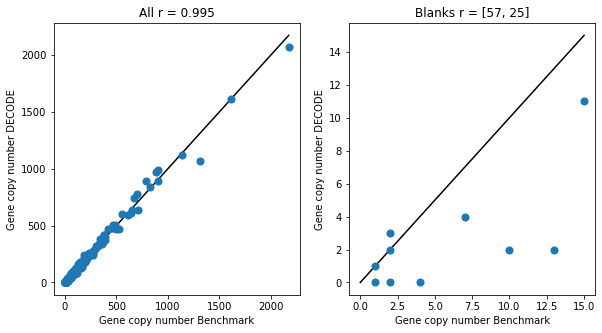

In [81]:
plot_gene_panels(istd_df_full.nlargest(36480 , 'quality'), bench_151, targets)

In [22]:
file_nrs = [47,150,151]

smoother = GaussianSmoothing(smoothing_filter_size=1., z_size=1, device='cpu')

for fnr in file_nrs:
    
    img_5d = read_MOp_tiff(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_scaled4_images{fnr}.tif', z_to_batch=True)
    micro_sd = torch.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_32/target_mean:Trueximage_path:scaled4_images{fnr}.tif/microscope.pkl')
    ch_facs = micro_sd['channel_facs'][None,:,None,None,None].cpu()
    
    bg = smoother(img_5d)
    img_corr = (img_5d - bg).detach().cpu()
    
    istd_df_full = get_istdeco_df_2048(torch.clamp_min(img_corr*ch_facs + 100, 0), codebook.reshape([252,11,2], order='F'), psf_sig=(1.3, 1.3), n_iter=50, bg=100, device='cuda')
        
    istd_df_full = istd_df_full.nlargest(200000, 'quality')
    istd_df_full['loc_idx'] = np.arange(len(istd_df_full))
    istd_df_full['gene'] = targets[istd_df_full['code_inds']]
    istd_df_full['class'] = istd_df_full['gene'].str.contains('Blank')
        
    istd_df_full.to_csv(f'../data/results/MERFISH/MOp_istdeco/sweep_mop_32_norm_{fnr}.csv')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:41<00:00, 31.63s/it]


In [ ]:
    istd_df_full = remove_doublets(istd_df_full, tolerance=200)
    istd_df_full = exclude_borders(istd_df_full, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
    istd_df_full = remove_fids(istd_df_full, px_to_nm(artifact_coords), tolerance=1000)